## Setting Up:

In [ ]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import zipfile
import cdsapi
import numpy as np
import glob
import xarray as xr
import massbalancemachine as mbm

from scripts.config_ICE import *

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

## Download monthly ERA5-Land variables:

To download ERA5-Land data you need to configure your API client first. For this, follow these instructions: https://forum.ecmwf.int/t/step-by-step-instructions-on-how-to-download-data-using-new-climate-data-store-beta-cds-beta/3743. 

To summarize instructions: 
- Your existing CDS credentials will not work in CDS-Beta, you need to have an ECMWF account - register one here: https://www.ecmwf.int/. 
- Once you have set up an account, make sure that you accepted licences in the Download form of the product page: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land-monthly-means?tab=download. 
- Make sure that you are logged in ECMWF then navigate to the CDSAPI setup page to copy the content for your .cdsapirc file: https://cds.climate.copernicus.eu/how-to-api. 

Once this is set up, you should be able to download the ERA5-Land data using our script. 

In [2]:
RUN = True
if RUN:
    os.makedirs(path_ERA5_raw, exist_ok=True)
    c = cdsapi.Client()

    # climate variables
    c.retrieve(
        'reanalysis-era5-land-monthly-means', {
            'product_type': ['monthly_averaged_reanalysis'],
            'variable': [
                '10m_u_component_of_wind',
                '10m_v_component_of_wind',
                '2m_temperature',
                'forecast_albedo',
                'snow_cover',
                'snow_density',
                'snow_depth_water_equivalent',
                'snowfall',
                'snowmelt',
                'surface_latent_heat_flux',
                'surface_net_thermal_radiation',
                'surface_sensible_heat_flux',
                'surface_solar_radiation_downwards',
                'total_precipitation',
            ],
            'year': [
                '1950',
                '1951',
                '1952',
                '1953',
                '1954',
                '1955',
                '1956',
                '1957',
                '1958',
                '1959',
                '1960',
                '1961',
                '1962',
                '1963',
                '1964',
                '1965',
                '1966',
                '1967',
                '1968',
                '1969',
                '1970',
                '1971',
                '1972',
                '1973',
                '1974',
                '1975',
                '1976',
                '1977',
                '1978',
                '1979',
                '1980',
                '1981',
                '1982',
                '1983',
                '1984',
                '1985',
                '1986',
                '1987',
                '1988',
                '1989',
                '1990',
                '1991',
                '1992',
                '1993',
                '1994',
                '1995',
                '1996',
                '1997',
                '1998',
                '1999',
                '2000',
                '2001',
                '2002',
                '2003',
                '2004',
                '2005',
                '2006',
                '2007',
                '2008',
                '2009',
                '2010',
                '2011',
                '2012',
                '2013',
                '2014',
                '2015',
                '2016',
                '2017',
                '2018',
                '2019',
                '2020',
                '2021',
                '2022',
                '2023',
                '2024',
            ],
            'month': [
                '01',
                '02',
                '03',
                '04',
                '05',
                '06',
                '07',
                '08',
                '09',
                '10',
                '11',
                '12',
            ],
            'time': ['00:00'],
            "data_format":
            "netcdf",
            "download_format":
            "zip",
            'area': [   # Iceland including Alps
                67,    # North latitude
                -25,     # West longitude
                42,    # South latitude
                17,    # East longitude
            ]
        }, path_ERA5_raw + 'download.netcdf.zip')
    with zipfile.ZipFile(path_ERA5_raw + 'download.netcdf.zip', 'r') as zip:
        zip.extractall(path_ERA5_raw)

    
    # geopot from era5-land reanalysis directly (new product with better resolution)
    # download it separately so that the pipeline still works
    c.retrieve(
        'reanalysis-era5-land-monthly-means', {
            "variable": ["geopotential"],
            "data_format": "netcdf",
            "download_format": "zip",
            'area': [   # Iceland including Alps
                67,    # North latitude
                -25,     # West longitude
                42,    # South latitude
                17,    # East longitude
            ]
        }, path_ERA5_raw + 'download_geopot.netcdf.zip')
    with zipfile.ZipFile(path_ERA5_raw + 'download_geopot.netcdf.zip', 'r') as zip:
        zip.extractall(path_ERA5_raw)


2025-06-05 09:11:57,869 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-05 09:11:58,067 INFO Request ID is 64018222-1adc-46db-9f9f-507ebdc5073b
2025-06-05 09:11:58,123 INFO status has been updated to accepted
2025-06-05 09:12:31,117 INFO status has been updated to successful


c201c3a550466fddb52b669496a9f719.zip:   0%|          | 0.00/0.99G [00:00<?, ?B/s]

2025-06-05 09:13:15,650 INFO Request ID is 3124e0ca-61a4-403b-9521-15ca8eea56ef
2025-06-05 09:13:15,715 INFO status has been updated to accepted
2025-06-05 09:13:29,527 INFO status has been updated to successful


bf8ccc44217bfcf37f3c1a63d9acb1fb.zip:   0%|          | 0.00/838k [00:00<?, ?B/s]

In [3]:
! ls "{path_ERA5_raw}"

data_stream-moda.nc	    era5_geopotential_pressure_ICECH.nc
download_geopot.netcdf.zip  era5_monthly_averaged_data_ICECH.nc
download.netcdf.zip	    geo.area-subset.67.17.42.-25.nc


In [4]:
# Correct era5 data
dc = xr.open_dataset(path_ERA5_raw + 'data_stream-moda.nc')
dc2 = dc.rename(
    {'valid_time': 'time'}
)  # Coordinates have changed recently in the API, this is to keep compatibility with our code

# delete file if already exists
if os.path.exists(path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc'):
    os.remove(path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc')
dc2.to_netcdf(path_ERA5_raw + "era5_monthly_averaged_data_ICECH.nc")

# change name of geopotential file: 
dc = xr.open_dataset(path_ERA5_raw + 'geo.area-subset.67.17.42.-25.nc')

# delete file if already exists
if os.path.exists(path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'):
    os.remove(path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc')
dc.to_netcdf(path_ERA5_raw + "era5_geopotential_pressure_ICECH.nc")

# delete old files
os.remove(path_ERA5_raw + 'download.netcdf.zip')
os.remove(path_ERA5_raw + 'data_stream-moda.nc')
os.remove(path_ERA5_raw+'download_geopot.netcdf.zip')
os.remove(path_ERA5_raw+'geo.area-subset.67.17.42.-25.nc')


In [5]:
! ls "{path_ERA5_raw}"

era5_geopotential_pressure_ICECH.nc  era5_monthly_averaged_data_ICECH.nc


### Check geopotential data:

<xarray.Dataset> Size: 848kB
Dimensions:    (time: 1, latitude: 251, longitude: 421)
Coordinates:
  * longitude  (longitude) float32 2kB 335.0 335.1 335.2 ... 16.8 16.9 17.0
  * latitude   (latitude) float32 1kB 67.0 66.9 66.8 66.7 ... 42.2 42.1 42.0
  * time       (time) datetime64[ns] 8B 2013-08-09T12:00:00
Data variables:
    z          (time, latitude, longitude) float64 845kB ...
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

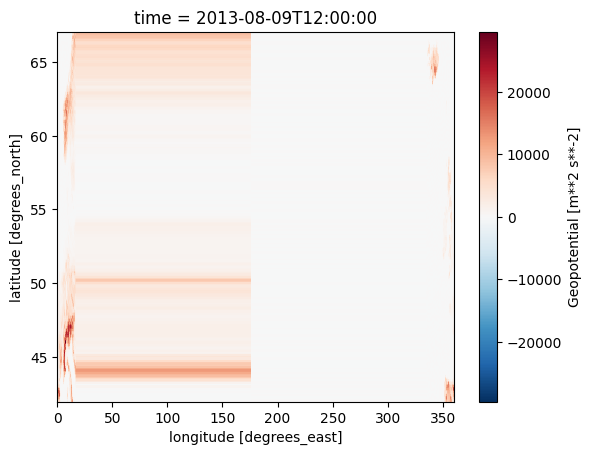

In [6]:
geopot_era5 = xr.open_dataset(path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc')
display(geopot_era5)

geopot_era5_sorted = geopot_era5.sortby('longitude')
# plot geopot new
geopot_era5_sorted.z.plot()